**Requirements:** Please install NumPyro by running:

```$ pip install --upgrade numpyro```

In [1]:
from functools import partial

# Regular Numpy (without an autograd/JAX wrapper around it)
import numpy
import numpyro
import scipy.stats

import matplotlib.pyplot as plt
%matplotlib inline

from bnn import feedforward
from inference import sample, simulate_pp, fit_advi, get_metrics
from data import *
from plotting import *

In [2]:
# Configure matplotlib format and default dimensions
%config InlineBackend.figure_formats = ['svg']
plt.rc("figure", figsize=(7, 3.5))

# Perform inference using a CPU and 2 cores
numpyro.set_platform("cpu")
numpyro.set_host_device_count(2)

In [4]:
def sample_and_plot(df, func, *, hidden, width, sigma, noise, num_samples, num_warmup, num_chains):
    """A helper function to instantiate the model, sample from the posterior, simulate
    the posterior predictive and plot it against the observations and the true function.
    """
    # Observations
    X = df[["x"]].values
    Y = df[["y"]].values
    X_test = numpy.linspace(X.min(), X.max(), num=1000)[:, numpy.newaxis]
    
    # Instantiate the model with a network architecture, prior standard deviation and likelihood noise
    model = partial(feedforward, X=X, Y=Y, width=width, hidden=hidden, sigma=sigma, noise=noise)

    # Run the No-U-Turn sampler
    mcmc = sample(model, num_samples, num_warmup, num_chains, seed=0, summary=False)
    
    # Generate the posterior predictive and plot the results
    posterior_predictive = simulate_pp(model, mcmc, X_test, seed=1)
    plot_posterior_predictive(
        X_test,
        posterior_predictive,
        func=func,
        df=df,
        title=f"BNN with {width} Nodes in {hidden} Hidden Layer{'' if hidden == 1 else 's'},\n"
        f"Weight Uncertainty {sigma}, Noise {noise}, NUTS Sampling",
    )
    
    # Print the diagnostic tests
    diagnostics=get_metrics(mcmc)
    message = ('Minimum ESS: {min_ess:,.2f}\n'
               'Max Gelman-Rubin: {max_rhat:.2f}').format(**diagnostics)
    plt.gcf().text(0.95, 0.15, message)
    
    # Return the fitted MCMC object to enable detailed diagnostics, e.g. mcmc.print_summary()
    return mcmc

In [13]:
def fit_and_plot(df, func, *, hidden, width, sigma, noise, num_iter, learning_rate):
    """A helper function to instantiate the model, approximate the posterior using Variational Inference
    with reparametrization and isotropic Gaussians, simulate the posterior predictive and plot it
    against the observations and the true function.
    """
    # Observations
    X = df[["x"]].values
    Y = df[["y"]].values
    X_test = numpy.linspace(X.min(), X.max(), num=1000)[:, numpy.newaxis]
    
    # Instantiate the model with a network architecture, prior standard deviation and likelihood noise
    model = partial(feedforward, X=X, Y=Y, width=width, hidden=hidden, sigma=sigma, noise=noise)

    # Approximate the posterior using Automatic Differentiation Variational Inference
    vi = fit_advi(model, num_iter=num_iter, learning_rate=learning_rate, seed=0)
    
    # Generate the posterior predictive and plot the results
    posterior_predictive = simulate_pp(model, vi, X_test, n_samples=1000, seed=1)
    plot_posterior_predictive(
        X_test,
        posterior_predictive,
        func=func,
        df=df,
        title=f"BNN with {width} Nodes in {hidden} Hidden Layer{'' if hidden == 1 else 's'},\n"
        f"Weight Uncertainty {sigma}, Noise {noise}, VI Approximation",
    )
    # Return the variation inference object to enable diagnostics, e.g. vi.plot_loss()
    return vi

# Accurate Uncertainties for Deep Learning Using Calibrated Regression

Analysis of the paper by [Kuleshov et al. (2018)](https://arxiv.org/pdf/1807.00263)

Project team: Piotr Pekala, Benjamin Yuen, Dmitry Vukolov, Alp Kutlualp

# Outline

1. Problem statement: miscalibration and its sources
2. Related work
3. Proposed calibration algorithm
4. Experiments
5. Evaluation of the claims
6. Future work

# Problem Statement

# The Issue of Miscalibration

**Problem statement:** Proper quantification of uncertainty is crucial for applying statistical models to real-world situations. The Bayesian approach to modeling provides us with a principled way of obtaining such uncertainty estimates. Yet, due to various reasons, such estimates are often inaccurate. For example, a 95% posterior predictive interval does not contain the true outcome with 95% probability.

**Context:** <mark>why is this problem important or interesting? any examples?</mark>

# Sources of Miscalibration

Below we demonstrate that the problem of miscalibration exists and show why it exists for **Bayesian neural networks** in regression tasks. We focus on the following sources of miscalibration:
- The **prior** is wrong, e.g. too strong and overcertain
- The **likelihood function** is wrong. There is bias, i.e. the neural network is too simple and is unable to model the data.
- The **noise** specification in the likelihood is wrong.
- The **inference** is approximate or is performed incorrectly.

Our aim is to establish a causal link between each aspect of the model building process and a bad miscalibrated outcome.

# Methodology

1. **Data Generation:** We generate the data from a known true function with Gaussian noise. We then build multiple feedforward BNN models using:
  - different network architectures
  - several priors on the weights, depending on model complexity
  - different variance of the Gaussian noise in the likelihood function
  
2. **Inference**: We then obtain the posterior of the model by:
  - sampling from it with the No-U-Turn algorithm
  - approximating the posterior using Variational Inference with reparametrization and isotropic normals
  
3. **Diagnostics**: We check for convergence using trace plots, the effective sample size, and Gelman-Rubin tests. In the case of variational inference, we track the ELBO during optimization. The simulated posterior predictive is evaluated visually.

The probabilistic library [NumPyro](https://github.com/pyro-ppl/numpyro) provides fast implementations of both algorithms, which we make use of in this research. Due to time constraints we do not perform multiple random restarts, so the results may be subject to randomness.

# Example: a Toy Dataset

Using a simple data-generating function $y_i = 0.1 x^3_i + \varepsilon$, where $\varepsilon \sim \mathcal{N}(0, 0.5^2)$ and a series of BNN models we evaluate the impact of our design choices on the posterior predictive.

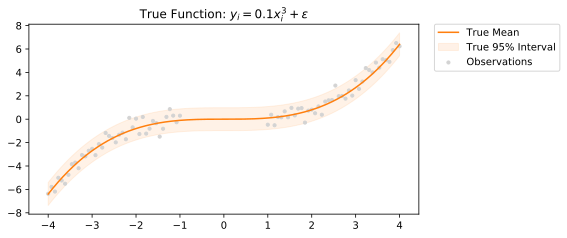

In [3]:
# Define the true function and generate observations
func = lambda x: scipy.stats.norm(loc=0.1 * x ** 3, scale=0.5)
func.latex = r"$y_i = 0.1x_i^3 + \varepsilon$"

data_points = [
    {"n_points": 40, "xlim": [-4, -1]},
    {"n_points": 40, "xlim": [1, 4]},
]
df = generate_data(func, points=data_points, seed=4)

# Plot the data
plot_true_function(func, df, title=f"True Function: {func.latex}")

# Proper Posterior Predictive

A neural network with 50 nodes in a single hidden layer, well-chosen prior and noise, as well as correctly performed inference using sampling produce a posterior predictive that adequately reflects both epistemic and aleatoric uncertainty:

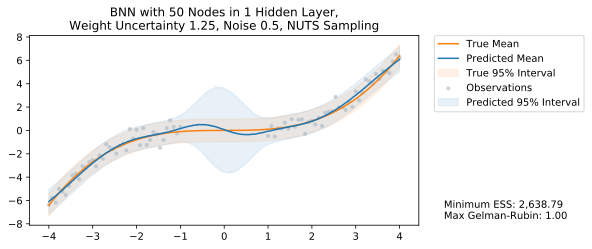

In [5]:
# Parameters of a Bayesian neural network
model_params = {
    # Number of hidden layers
    "hidden": 1,
    # Width of hidden layers
    "width": 50,
    # Standard deviation of the prior
    "sigma": 1.25,
    # Standard deviation of the likelihood
    "noise": 0.5,
}

# NUTS sampler parameters
sampler_params = {
    "num_chains": 2,
    "num_samples": 2000,
    "num_warmup": 2000,
}

# Run the No-U-Turn sampler, generate the posterior predictive and plot it
mcmc = sample_and_plot(df, func, **model_params, **sampler_params)

Naturally, our claims regarding the adequacy of epistemic uncertainty are subjective due to the absence of universal quantitative metrics.

# Wrong Prior: Too Wide

The prior on the network weights defines epistemic uncertainty. A higher than necessary variance of the prior results in a significantly larger and most likely unreasonable epistemic uncertainty:

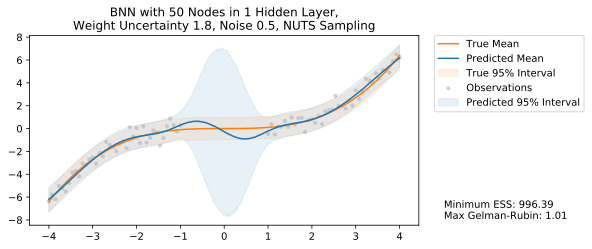

In [6]:
model_params = {
    "hidden": 1,
    "width": 50,
    "sigma": 1.8,
    "noise": 0.5,
}
# Run the No-U-Turn sampler, generate the posterior predictive and plot it
mcmc = sample_and_plot(df, func, **model_params, **sampler_params)

# Wrong Prior: Too Narrow

Lower variance of the prior prevents the model from adequately reflecting epistemic uncertainty in areas where no data is available. It also introduces bias: a neural network with 50 nodes in a single hidden layer (i.e. 151 weights) is unable to fit a cubic function:

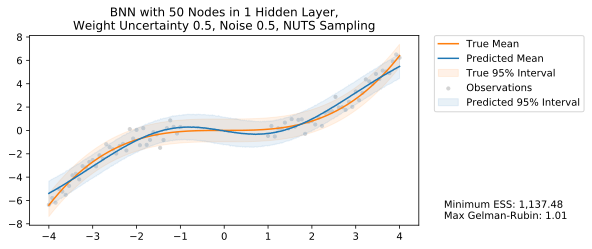

In [7]:
model_params = {
    "hidden": 1,
    "width": 50,
    "sigma": 0.5,
    "noise": 0.5,
}
# Run the No-U-Turn sampler, generate the posterior predictive and plot it
mcmc = sample_and_plot(df, func, **model_params, **sampler_params)

# Wrong Prior: Extremely Restrictive

The bias becomes apparent with an even narrower prior on the weights. This is a major issue with the model that needs to be fixed. Calibration is inappropriate in this case.

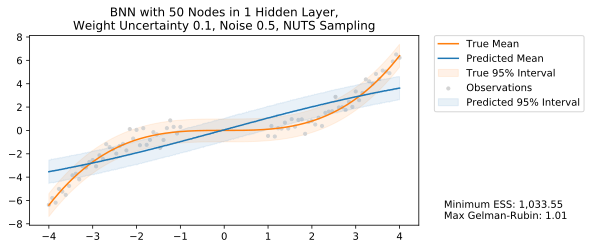

In [8]:
model_params = {
    "hidden": 1,
    "width": 50,
    "sigma": 0.1,
    "noise": 0.5,
}
# Run the No-U-Turn sampler, generate the posterior predictive and plot it
mcmc = sample_and_plot(df, func, **model_params, **sampler_params)

# Wrong Likelihood Function

Similar to the previous example, a BNN may demonstrate bias by beeing too simple architecturally. That is difficult to demonstrate for a dataset generated by a cubic function (can be described by just 4 points). Still, we can try a combination of the prior and noise specification from the proper model and reduce the number of nodes. The sampler does not converge in this setup.

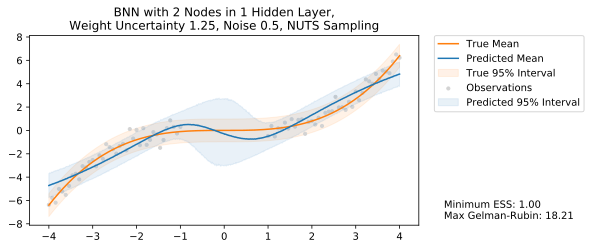

In [9]:
model_params = {
    "hidden": 1,
    "width": 2,
    "sigma": 1.25,
    "noise": 0.5,
}
# Run the No-U-Turn sampler, generate the posterior predictive and plot it
mcmc = sample_and_plot(df, func, **model_params, **sampler_params)

# Link Between Prior and Network Architecture

The appropriate level of the prior variance depends on the network complexity. A simpler network with 10 nodes and the same prior variance as our original benchmark model predicts much lower epistemic uncertainty. Therefore, the prior has to be selected for each particular network configuration.

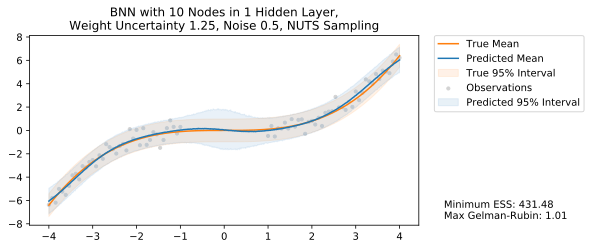

In [10]:
model_params = {
    "hidden": 1,
    "width": 10,
    "sigma": 1.25,
    "noise": 0.5,
}
# Run the No-U-Turn sampler, generate the posterior predictive and plot it
mcmc = sample_and_plot(df, func, **model_params, **sampler_params)

# Wrong Noise: Too High

The noise in the likelihood function corresponds to aleatoric uncertainty. The effect of the wrong noise specification is that aleatoric uncertainty is captured incorrectly. In the model below the noise is still Gaussian, but has a higher variance than the true one:

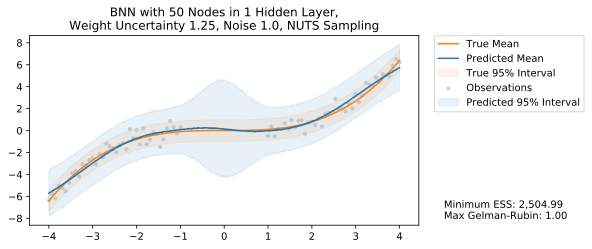

In [11]:
model_params = {
    "hidden": 1,
    "width": 50,
    "sigma": 1.25,
    "noise": 1.0,
}
# Run the No-U-Turn sampler, generate the posterior predictive and plot it
mcmc = sample_and_plot(df, func, **model_params, **sampler_params)

This might be a good candidate for calibration. Alternatively, one could find ways for the network to learn the noise from the data or put an additional prior on the variance of the noise.

# Wrong Noise: Too Small

Similarly, if the noise is too small, the resulting aleatoric uncertainty captured by the posterior predictive will be unrealistically low:

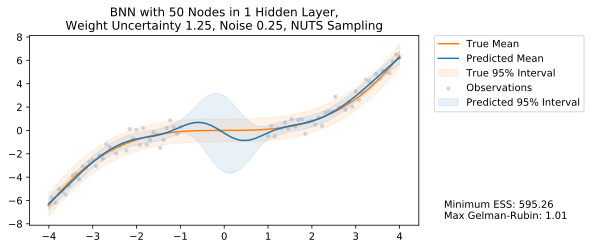

In [12]:
model_params = {
    "hidden": 1,
    "width": 50,
    "sigma": 1.25,
    "noise": 0.25,
}
# Run the No-U-Turn sampler, generate the posterior predictive and plot it
mcmc = sample_and_plot(df, func, **model_params, **sampler_params)

# Approximate Inference

Using approximate methods of inference is also likely to lead to a miscalibrated posterior predictive. In the example below, Variational Inference with reparametrization on a network with 50 nodes produces too low epistemic uncertainty and slightly larger aleatoric uncertainty. Calibration may be used for correcting the latter.

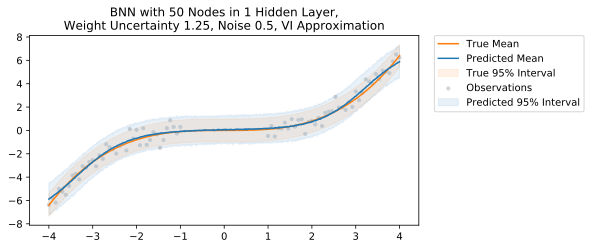

In [14]:
model_params = {
    "hidden": 1,
    "width": 50,
    "sigma": 1.25,
    "noise": 0.5,
}

vi_params = {
    "num_iter": 500_000,
    "learning_rate": 0.001,
}

# Approximate the posterior with Variational Inference, generate the posterior predictive and plot it
vi = fit_and_plot(df, func, **model_params, **vi_params)

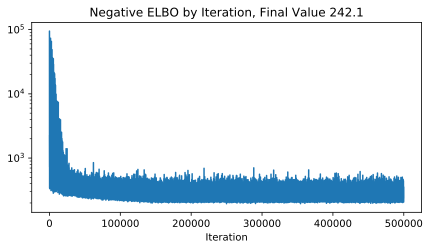

In [15]:
# Plot the negative ELBO for diagnostics
vi.plot_loss()

# Related Work